In [ ]:
import numpy as np
import pickle
from time import time
from joblib import Parallel, delayed
import sys

import torch
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm,trange
import os


from src.data.loading.dataset_rydberg import RydbergDataset,unif_sample_on_grid

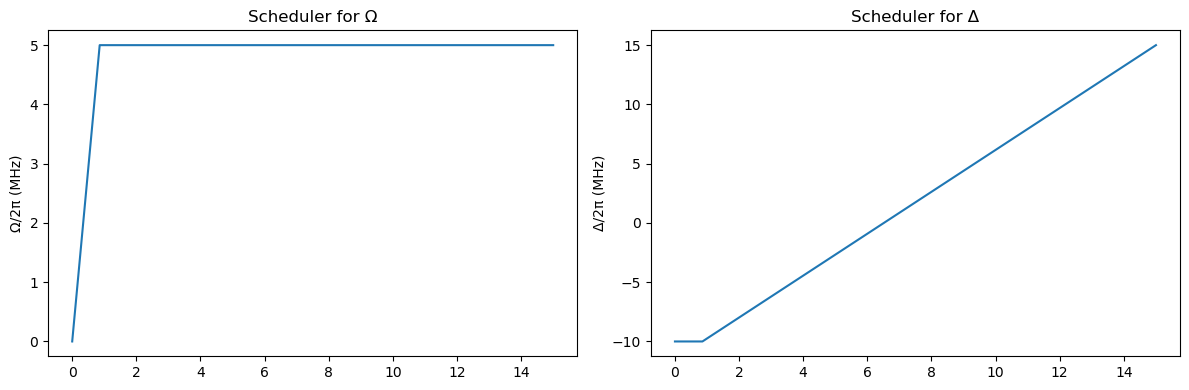

In [4]:

# Here we define a base schedule -- 
base_time = 3.5
ts = np.array([0,0.2,base_time])
omegas = np.array([0, 5, 5])
deltas = np.array([-10, -10, 15])
total_time = 15 # Total adiabatic evolution time of the Bloqade simulation
# We propotionally lengthen the schedules for Omega and Delta by time_ratio = total_time/base_time
time_ratio = total_time/base_time


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
ax1.plot(ts*time_ratio, omegas)
ax1.set_ylabel("Ω/2π (MHz)")
ax1.set_title("Scheduler for Ω")
ax2.plot(ts*time_ratio, deltas)
ax2.set_ylabel("Δ/2π (MHz)")
ax2.set_title("Scheduler for Δ")
fig.tight_layout()

In [ ]:
n_qubits = 31 # number of Rydberg atoms in the 1D lattice

dim=1 # dimension of the system
ny = 1 # since we are working in 1D, this variable is fixed to 1
nx = n_qubits # effectively, we are working on a 2D lattice of dimensions nx*ny, where nx=n_qubits and ny=1.
z2_threshold=0.7 # threshold for the Z2 order parameter to determine a state is in Z2 phase
z3_threshold = 0.6 # threshold for the Z3 order parameter to determine a state is in Z3 phase

# We load simulation data for the lattice defined above with the adiabatic evolution scheduler preset above.
folder = f'data/rydberg/1D-Phase_{nx}/{float(np.round(total_time,2))}µs/'

# extra variables we want the conditional generative variable to condition on, except for "nx", "ny", "interaction_range".
# detuning = Delta/Omega
extra_variables = ["detuning",] 
meta_dataset = RydbergDataset(dim=dim,nx = nx, ny=ny, folder=folder,n_threads=20, 
                                         var_name='interaction_range',variables = extra_variables) 
meta_dataset.est_order_params()
meta_dataset.info["phase" ] = determine_phase_1D(meta_dataset.info["Z2"], meta_dataset.info["Z3"],z2_threshold=z2_threshold,
                                                z3_threshold=z3_threshold
                                            )